In [1]:
from bs4 import BeautifulSoup
import requests
# import json, os
import pandas as pd
# from pandas.io.json import json_normalize

In [2]:
# https://au.indeed.com/cmp/Origin-Energy/reviews?start=10
# increment 'start=XX' by 10 for each subsequent page

url = "https://au.indeed.com/cmp/Origin-Energy/reviews?start="

pageNum = "10"

# lets create a function to deal with a page
def getDataFromPage(url, pageNum):
    rawPage = requests.get(url + pageNum)
    data = rawPage.text
    soup = BeautifulSoup(data, 'lxml')
    
    # create placeholder dataframe
    df = pd.DataFrame(columns=["Title", 
                               "Position", 
                               "Location", 
                               "Date",
                               "Description", 
                               "Pros", 
                               "Cons"])
    
    # break up page into individual reviews
    for index, review in enumerate(soup.find_all('div', {'class': 'cmp-review'})):
#         print(index, "   Title: ", review.find('div', {'class': 'cmp-review-title'}).text)
        
        # not all rows have a pro or con listed, put a try/except error catch in
        try:
            pro = review.find('div', {'class': 'cmp-review-pro-text'}).text,
        except:
            pro = ""
        try:
            con = review.find('div', {'class': 'cmp-review-con-text'}).text,
        except:
            con = ""
        
        # add review as a row to the pandas dataframe
        df.loc[index] = [
            review.find('div', {'class': 'cmp-review-title'}).text,
            review.find('span', {'class': 'cmp-reviewer'}).text,
            review.find('span', {'class': 'cmp-reviewer-job-location'}).text,
            review.find('span', {'class': 'cmp-review-date-created'}).text,
            review.find('div', {'class': 'cmp-review-description'}).text,
            pro,
            con,
        ]
    # return dataframe
    return df

# testing - show the first 5 rows
soup = getDataFromPage(url, pageNum)
soup.head(1)

Title  \
0  Corporate level positive, department level neg...   

                     Position                        Location          Date  \
0  DRAWING OFFICE COORDINATOR  Melbourne, Victoria, Australia  3 April 2017   

                                         Description  \
0  Workplace culture preached positive things and...   

                              Pros                     Cons  
0  (Lovely teas and lunch rooms.,)  (hassles and meetings,)

In [3]:
## setup a loop to iterate over all pages
# checking last page, page 6 has review number 100 & there are 10 per page

# create placeholder dataframe
df = pd.DataFrame(columns=["Title", 
                           "Position", 
                           "Location", 
                           "Date",
                           "Description", 
                           "Pros", 
                           "Cons"])

# generate page number count and iterate over pages
for pageNum in range(10, 120, 10):
    try:
        soup = getDataFromPage(url, str(pageNum))
        print("querying page: ", pageNum)
        df = df.append(soup)
        print("saving page: ", pageNum)
    except:
        print("Error ", pageNum)


# save the dataframe so we aren't constantly hitting the indeed page
df.to_pickle("indeedRawDf.df")

querying page:  10
saving page:  10
querying page:  20
saving page:  20
querying page:  30
saving page:  30
querying page:  40
saving page:  40
querying page:  50
saving page:  50
querying page:  60
saving page:  60
querying page:  70
saving page:  70
querying page:  80
saving page:  80
querying page:  90
saving page:  90
querying page:  100
saving page:  100
querying page:  110
saving page:  110


In [4]:
# Open dataframe (saved previously after scrape)
df = pd.read_pickle("indeedRawDf.df")
# Remove duplicates
df2 = df.drop_duplicates(subset=None, keep='first', inplace=False)

# let's have a peek at the data
print(len(df2), " rows in dataframe.")
df2.head(2)

121  rows in dataframe.


Title  \
0  Corporate level positive, department level neg...   
1                       Great environment to work in   

                                 Position                        Location  \
0              DRAWING OFFICE COORDINATOR  Melbourne, Victoria, Australia   
1  LPG eAMS Maintenance Planner Australia                    Brisbane QLD   

                Date                                        Description  \
0       3 April 2017  Workplace culture preached positive things and...   
1  11 September 2018  Origin, is a fast paced working environment  t...   

                              Pros                     Cons  
0  (Lovely teas and lunch rooms.,)  (hassles and meetings,)  
1

In [5]:
# lets parse the date so we can use it
df2['Date']  = pd.to_datetime(df2['Date'])
df2['Date'].head(2)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0   2017-04-03
1   2018-09-11
Name: Date, dtype: datetime64[ns]

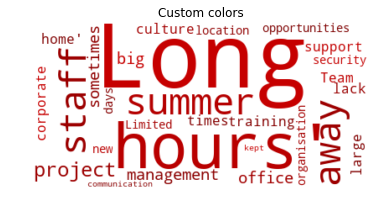

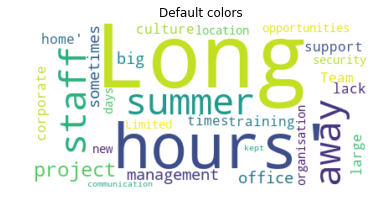

In [5]:
# Lets create a word cloud of the descriptions
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS

# Joining all the Cons
consText = ""    
for ind, column in enumerate(df2["Cons"]):
    consText += str(column)

text = consText

# adding irellevant specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("work")
stopwords.add("worked")
stopwords.add("working")
stopwords.add("workers")
stopwords.add("poor")
stopwords.add("Job")

wc = WordCloud(max_words=100, 
#                mask=mask, 
               stopwords=stopwords, 
               margin=2, 
               background_color='white', 
               min_font_size=10,
               random_state=3).generate(text)

# define green generator
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "rgb(" + str(random.randint(120, 200)) +  ", 0, 0)"

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=0),
           interpolation="bilinear")
wc.to_file("originWordCloudCon.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

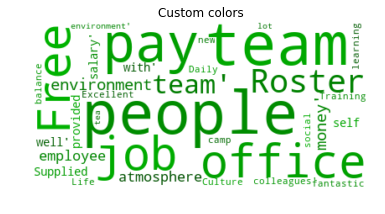

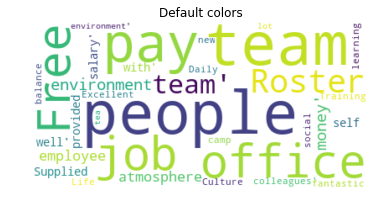

In [6]:
# Lets create a word cloud of the descriptions
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS

# Joining all the Pros
prosText = ""    
for ind, column in enumerate(df2["Pros"]):
    prosText = prosText + str(column)

text = prosText

# adding irellevant specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("work")
stopwords.add("worked")
stopwords.add("working")
stopwords.add("workers")
stopwords.add("good")
stopwords.add("great")

wc = WordCloud(max_words=100, 
#                mask=mask, 
               stopwords=stopwords, 
               margin=2, 
               background_color='white', 
               min_font_size=10,
               random_state=3).generate(text)


# define greyscale generator
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "rgb(0," + str(random.randint(80, 180)) +  ", 0)"

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=0),
           interpolation="bilinear")
wc.to_file("originWordCloudPro.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

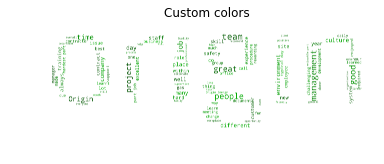

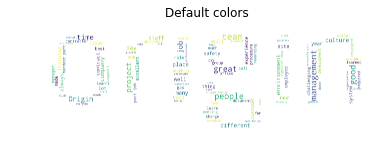

In [11]:
# Lets create a word cloud of the descriptions
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import os
import random

from wordcloud import WordCloud, STOPWORDS

# join all the description text into one big string
descriptionText = ""    
for ind, column in enumerate(df2["Description"]):
    descriptionText = descriptionText + column

text = descriptionText

# read the mask image taken from (the origin logo)
mask = np.array(Image.open("origin4.png"))

# adding irellevant specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("work")
stopwords.add("worked")
stopwords.add("working")
stopwords.add("workers")

wc = WordCloud(max_words=100, 
               mask=mask, 
               stopwords=stopwords, 
               margin=2, 
               background_color='white', 
               min_font_size=10,
               random_state=3).generate(text)


# define greyscale generator
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    if prosText.find(word):
        return "rgb(0," + str(random.randint(80, 180)) +  ", 0)"
    elif consText.find(word):
        return "rgb(" + str(random.randint(120, 200)) +  ", 0, 0)"
    else:
        return "hsl(0, 0%%, %d%%)" % random.randint(10, 20)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=0),
           interpolation="bilinear")
wc.to_file("originWordCloud.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
datedf = df2['Date'].groupby([df2.Date.dt.year, df2.Date.dt.quarter]).agg('count')

datedf

Date  Date
2012  2        1
      3        2
      4        3
2013  2        1
      3        3
      4        2
2014  1        4
      2        1
      3        2
      4        6
2015  1        4
      2       13
      3        6
      4        6
2016  1       10
      2        6
      3        4
      4        3
2017  1       10
      2       10
      3        2
      4        3
2018  1        4
      2        7
      3        8
Name: Date, dtype: int64

In [134]:
# df2 = df2.sort_values(by='Date')

DateAgg = pd.DataFrame([df2['Date'].value_counts(), df2['Date'].value_counts().index])

DateAgg

2015-04  2017-04  2018-04  2018-08  2016-03  2015-05  2017-01  \
Date           7.0      6.0      5.0      5.0      5.0      4.0      4.0   
Unnamed 0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

           2015-09  2017-06  2016-01   ...     2017-05  2015-08  2014-07  \
Date           4.0      3.0      3.0   ...         1.0      1.0      1.0   
Unnamed 0      NaN      NaN      NaN   ...         NaN      NaN      NaN   

           2013-10  2016-11  2014-03  2014-05  2018-06  2013-07  2015-12  
Date           1.0      1.0      1.0      1.0      1.0      1.0      1.0  
Unnamed 0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[2 rows x 56 columns]

In [7]:
OriginIndeed = """3.8Work/Life Balance
3.9Salary/Benefits
3.2Job Security/Advancement
3.4Management
3.6Culture """

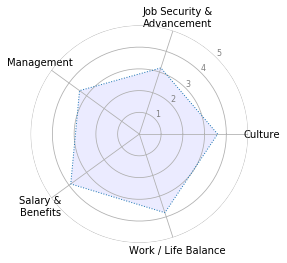

In [6]:

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'Culture': [3.6, 3.6, 3.6, 3.6],
'Job Security &\nAdvancement': [3.2, 3.2, 3.2, 3.2],
'Management': [3.4, 3.4, 3.4, 3.4],
'Work / Life Balance': [3.8, 3.8, 3.8, 3.8],
'Salary &\nBenefits': [3.9, 3.9, 3.9, 3.9],
})

# number of variable
categories=list(df)[0:5]
N = len(categories)

# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=10)

plt.box(on=None)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=8)
plt.ylim(0,5)

# Plot data
ax.plot(angles, values, linewidth=1, linestyle=':')

# Fill area
ax.fill(angles, values, 'b', alpha=0.08)

plt.savefig("radarGraph.svg")
plt.show()
